In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

%load_ext autoreload
%autoreload 2
from trader.utils import *
from trader.tradertk import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


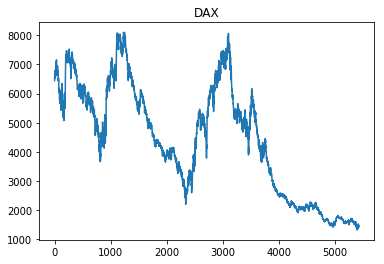

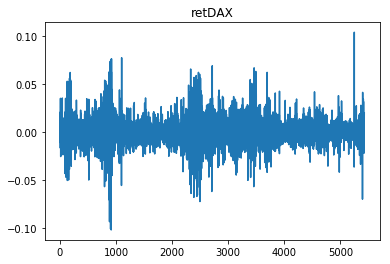

std(retDAX):  0.0147580478684


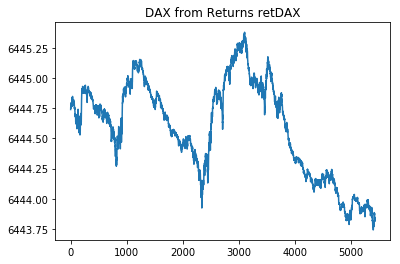

In [174]:
with open('data/retDAX.txt', 'r') as f:
    tmp = f.read()
    
retDAX = list(map(lambda x: float(x), tmp.split()))

with open('data/DAX.txt', 'r') as f:
    tmp = f.read()
    
DAX = list(map(lambda x: float(x), tmp.split()))


plt.plot(DAX)
plt.title('DAX')
plt.show()
plt.plot(retDAX)
plt.title('retDAX')
plt.show()

print('std(retDAX): ', np.std(retDAX))

tmp = [DAX[0]]
for x in retDAX:
    tmp.append(tmp[-1] + x)
    
plt.plot(tmp)
plt.title('DAX from Returns retDAX')
plt.show()

# Here goes the main part:

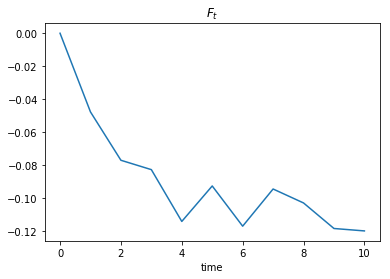

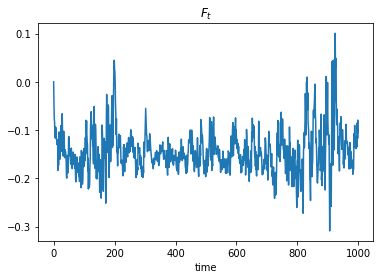

Rewards length = 1000


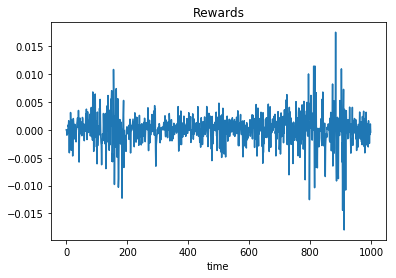

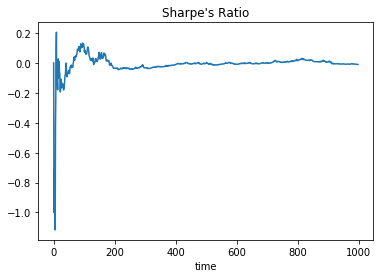

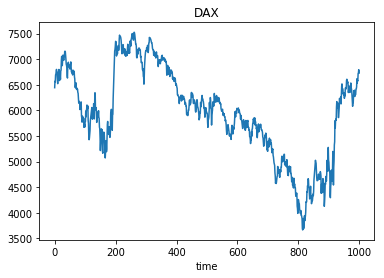

In [171]:
M = 10  # The number of time series inputs to the trader.
w = np.random.uniform(-1.0, 1.0, M+3)

X = []

for t in range(M+1):
    tmp = [1]
    tmp.extend(list(reversed(retDAX[:t+1])))
    tmp.extend([0 for i in range(M-t)])
    if t == 0:
        tmp.append(0)
    else:
        tmp.append(traderFunction(w, X[t-1]))
    X.append(tmp)

plt.plot(np.array(X)[:,M+2])
plt.title('$F_t$')
plt.xlabel('time')
plt.show()

maxT = 1000

for t in range(M+1, maxT):
    X.append(get_x(t, retDAX, w))
    
    
F = np.array(X)[:,M+2]

plt.plot(F)
plt.title('$F_t$')
plt.xlabel('time')
plt.show()

miu = 1  # Maximum possible number of shares per transaction
delta = 0.0001  # Cost for a transaction at period t

def get_reward(t_input, r_input, F_input, miu_input, delta_input):
    if t_input > 0:
        return miu_input * ((F_input[t_input-1] * r_input[t_input]) - \
                            (delta_input * abs(F_input[t_input] - F_input[t_input-1])))
    else:
        return 0

rewards = [get_reward(t, retDAX, F, miu, delta) for t in range(maxT)]
print('Rewards length =', len(rewards))

plt.plot(rewards)
plt.title('Rewards')
plt.xlabel('time')
plt.show()

srs = [sharpRatio(rewards[:t]) for t in range(1, maxT)]

plt.plot(srs)
plt.title("Sharpe's Ratio")
plt.xlabel('time')
plt.show()

plt.plot(DAX[:maxT])
plt.title('DAX')
plt.xlabel('time')
plt.show()

# It's time to calculate the gradient $\frac{\partial S_t}{\partial w}$

In [ ]:
grad = 0

someT = 50

learning_rate = 0.1

A = sum(rewards[:someT]) / someT
B = sum(np.array(rewards[:someT]) ** 2) / someT

dSdA = (1 / np.sqrt(B - (A ** 2))) + ((A ** 2) / (np.sqrt(B - (A ** 2)) ** 3))
dSdB = -1 * (A / (2 * ((np.sqrt(B - (A ** 2))) ** 3)))

for t in range(1, someT):
    dAdR = 1 / someT
    dBdR = 2 * rewards[t] / someT
    
    dRdFt = 
    dFtdw = 
    
    dRdFtt = 
    dFttdw = 
    
    grad += (dSdA*dAdR + dSdB*dBdR) * (dRdFt*dFtdw + dRdFtt*dFttdw)
    
grad

In [ ]:
w += learning_rate * grad  # weights update

In [8]:
with open('data/retDAX.txt', 'r') as f:
    tmp = f.read()
    
retDAX = list(map(lambda x: float(x), tmp.split()))

with open('data/DAX.txt', 'r') as f:
    tmp = f.read()
    
DAX = list(map(lambda x: float(x), tmp.split()))

#
# testDAX.m goes here
#

M = 10  # The number of time series inputs to the trader.
T = 500
N = 100

initial_theta = np.ones((M+2, 1))  # Initialize theta.

X = retDAX

Xn = featureNormalize(X)

# [theta, cost, EXITFLAG,OUTPUT] = fminunc(@(t)(costFunction(Xn(1:M+T), X(1:M+T), t)), initial_theta, options)

def costF(t):
    return costFunction(Xn[:M+T], X[:M+T], t)

minimize(costF, initial_theta)

# Ft = updateFt(Xn[:M+T], theta, T)


# # Ft = np.zeros((T+1, 1))
# # Ft = np.ones(T+1)  # Holdings at period t.


# miu = 1  # maximum possible number of shares per transaction
# delta = 0.001  # The cost for a transaction at period t

# Ret, sharp = rewardFunction(X, miu, delta, Ft, M)

[[ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]
 [ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]
 [ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]
 ..., 
 [ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]
 [ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]
 [ 0.10045591  0.10072639  0.10018872 ...,  0.09963479  0.10087404
   0.10049991]]
(10, 500)
(6000, 10)
(12, 12)
(12, 12)


ValueError: shapes (6000,10) and (12,12) not aligned: 10 (dim 1) != 12 (dim 0)

In [ ]:
def getNumericalGradient()

In [ ]:
def get_F(r, w):
    T = len(r)
    F = np.zeros(T)
    for t in range(1, T):
        x = np.hstack((1, r[t], F[t-1]))
        #print 'x: ', x.shape
        #print 'w: ', w.shape

        F[t] = np.tanh(np.dot(w, x))
    return F


def get_grad(r, w):
    eta = 0.5
    mu = 1
    delta = 0.001
    T = len(r)

    F = get_F(r, w)
#     R = get_return(r, F)
    R = rewardFunction(X, miu, delta, Ft, M)[0]
    A = 0
    B = 0
    T = len(R)
    for t in range(T - 1):
        A = A + eta * (R[t] - A)
        B = B + eta * (R[t]**2 - B)

    dDdR = (B  - A * R[T-1]) / (B - A**2)**(3/2)

    prefix = np.array([dDdR] * (T-1))

    dF = np.zeros([3, T])
    for t in range(1, T):
        xt = np.hstack((1, r[t], F[t-1]))
        dF[:,t] = (1 - np.tanh(np.dot(w, xt)) ** 2) * (xt + w[2] * dF[:,t-1])


    dRtFt = (-1) * mu * delta * np.sign(F[1:T] - F[0:T-1])
    dRtFtt = mu * r[1:T] + mu * delta * np.sign(F[1:T] - F[0:T-1])

    grad = np.sum(np.array([prefix] * 3) * (np.array([dRtFt] * 3) * dF[:, 1:T] +
                                            np.array([dRtFtt] * 3) * dF[:, 0:T-1]), axis=1)
    return grad


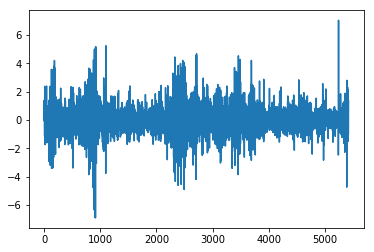

In [10]:
plt.plot(Xn)

In [9]:
# initial_theta = np.ones((M+2, 1))

tmp = costFunction(X, Xn, np.random.uniform(-1,1,(M+2, 1)))
tmp

[[ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]
 [ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]
 [ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]
 ..., 
 [ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]
 [ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]
 [ 8.29450156  7.84888441  8.73476943 ...,  8.29665594  8.20674132
   9.4075615 ]]
(10, 5415)
(64980, 10)
(12, 12)
(12, 12)


ValueError: shapes (64980,10) and (12,12) not aligned: 10 (dim 1) != 12 (dim 0)

In [55]:
np.tile([1,2,3], (M,1))

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])